In [134]:
import pandas as pd
from util import *
from datetime import date, datetime
from scipy.stats import pearsonr
import numpy as np

In [68]:
# Load some comments
df = pd.read_parquet(s3_to_local_path("processed/reddit/comments/wallstreetbets.parquet"))
df['dt'] = pd.to_datetime(df.dt, unit='ms')
df.rename(columns={'parent_id': 'id'}, inplace=True)
df.head()

,body,id,dt,score
0,"In the event it goes poorly, please show us **...",tddix,2012-05-08 22:01:39,13
1,**ಠ_ಠ**,c4ls64n,2012-05-09 01:51:35,18
2,"Sticking to my word, this is the only american...",c4lset2,2012-05-09 03:23:41,11
3,"Ok, I will give you a brief rundown of my risk...",c4lvfxc,2012-05-09 06:24:29,13
4,I'm glad you're documenting your gambling addi...,tggv0,2012-05-10 14:56:20,18


In [69]:
# Load some submissions
sub_df = pd.read_parquet(s3_to_local_path("processed/reddit/submissions/wallstreetbets.parquet"))
sub_df['dt'] = pd.to_datetime(sub_df.dt, unit='ms')
sub_df.head()

,title,subreddit,domain,id,dt,score
0,Earnings season is here. Place your bets.,wallstreetbets,self.wallstreetbets,s4jw1,2012-04-11 16:40:40,13
1,My poorly timed opening position for AAPL earn...,wallstreetbets,self.wallstreetbets,sd5ai,2012-04-16 22:29:37,12
2,New look. What's the outlook for this sub?,wallstreetbets,self.wallstreetbets,sz20k,2012-04-30 01:56:17,11
3,Haha. Shitty_RedditLogos proposes logo after ...,wallstreetbets,reddit.com,t3dqx,2012-05-02 15:29:12,12
4,GMCR earnings after market close today (5/2). ...,wallstreetbets,self.wallstreetbets,t3dfo,2012-05-02 15:22:31,12


In [70]:
# Get top comment by post
top_comments = df.sort_values('score').groupby('id').tail(1)
top_comments.head()

,body,id,dt,score
1781526,Always,gcftt2z,2020-11-15 23:37:05,10
826008,"Lmao, I like how everyone knows this is talkin...",fg6uw5m,2020-02-01 17:19:56,10
826012,🦇 🍲,fg6vleo,2020-02-01 17:25:46,10
4882487,Closing some CCs this morning on the dip! Earn...,h3k3izr,2021-06-30 14:04:33,10
826029,Holy shit I fell asleep about halfway through ...,fg6pwxt,2020-02-01 17:40:52,10


In [71]:
# Join
sub_df = sub_df.merge(
    top_comments[['id', 'body', 'score']].rename(columns={'body': 'top_comment', 'score': 'top_comment_score'}),
    on='id',
    how='left',
)
sub_df.dropna().head()

,title,subreddit,domain,id,dt,score,top_comment,top_comment_score
7,"Alright, I'm all in ($10k) on another crazy pe...",wallstreetbets,self.wallstreetbets,tddix,2012-05-08 19:18:39,17,"In the event it goes poorly, please show us **...",13.0
12,"After a two month break, I've come back having...",wallstreetbets,self.wallstreetbets,tire4,2012-05-11 21:09:14,12,But r/investing is great! Who doesn't like 5 t...,10.0
20,We’re putting an end to this: Options v. Penni...,wallstreetbets,self.wallstreetbets,tyb7h,2012-05-21 23:18:45,52,This subreddit just keeps getting more and mor...,15.0
30,Options v. Pennies: Day 2,wallstreetbets,self.wallstreetbets,ucv5h,2012-05-30 22:48:11,18,Up 70%...decides that's not enough profit...pr...,10.0
34,Options v. Pennies: Day 5 - A New Hope,wallstreetbets,self.wallstreetbets,ul5jm,2012-06-05 00:07:02,17,Can we get a little personal background from J...,10.0


To find the original post you can go to redd.it/id, the first row above (as I'm writing) brings us to [this post](https://www.reddit.com/r/wallstreetbets/comments/tddix/alright_im_all_in_10k_on_another_crazy_penny/).
Which is pretty much correct (Scores have changed a bit).

Also note that pandas coerces top_comment_score to a float float here to allow NaNs (no comments). If we want an int then you can dropna() rows and cast it back to an int.


<Axes: xlabel='date'>

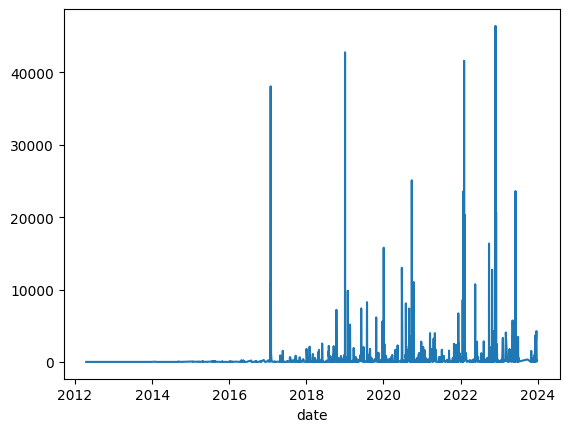

In [131]:
# Do some basic analysis - look for a ticker
apple = sub_df[sub_df.title.str.contains("AAPL") | sub_df.title.str.contains("Apple")].copy()
apple['date'] = apple.dt.dt.date
scores = apple.groupby('date').score.sum()
scores.plot()

This is super choppy. If we are forecasting say 20 days into the future, it would be silly to only look at todays data. We can take a rolling sum by date. We should probably fill missing days with zeros to ensure we always look at a fixed time period (rather than skipping empty days).

<Axes: >

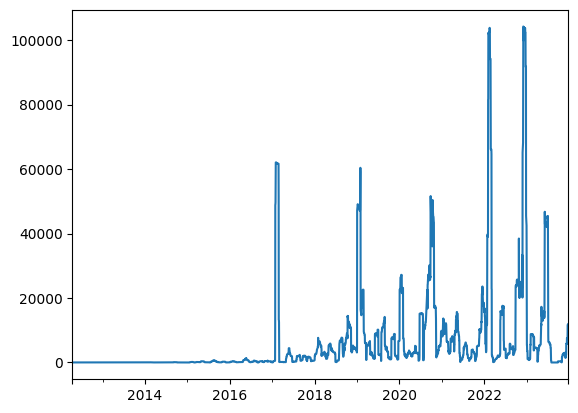

In [132]:
# Reindex to every day
start_date = apple.date.min()
end_date = apple.date.max()
new_idx = pd.date_range(start_date, end_date)
scores = apple.groupby('date').score.sum()
scores = scores.reindex(new_idx, fill_value=0)
scores = scores.rolling(30, min_periods=0).sum()
scores.plot()

This is a bit more useful, however I wouldn't feel comfortable putting these values directly into a model as we don't kno whow high future values could get! We probably want to normalise to some more stable range of values. 

One way would be to take a rolling z-score, i.e. (current value - mean(last year)) / s.d.(last year). We could also clip this to give more sensible values.

This still leaves a positive bias due to communities growing over time, but it's fine for now. A better approach might be taking (apple score) / (total score) over the last 30 days for all posts on a given subreddit.

There's also not much data before 2017 so we could start analysing from there.

<Axes: >

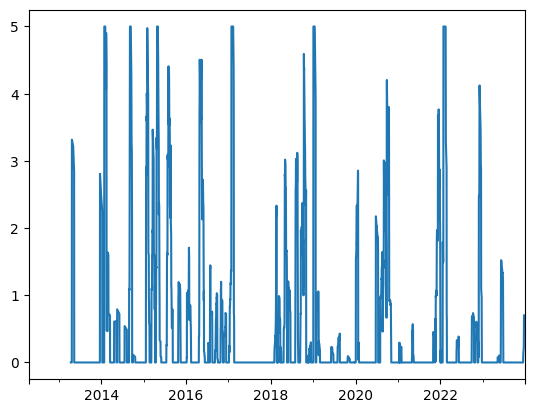

In [186]:
scores = apple.groupby('date').score.sum()
scores = scores.reindex(new_idx, fill_value=0)
scores = scores.rolling(20, min_periods=0).sum()
scores = ((scores - scores.rolling(365).mean()) / (scores.rolling(365).std())).clip(0, 5)
scores.plot()

Now we have an example 'signal'. For a quick test, I've attached a history of apple close prices in this folder.

In [187]:
prices = pd.read_csv("apple.csv").rename(columns={'Date': 'date', 'Close': 'close'})[['date', 'close']]
prices['date'] = pd.to_datetime(prices.date)
prices = prices.sort_values('date')

# Add scores
prices = prices.merge(scores.reset_index().rename(columns={'index': 'date'}), on='date', how='left')
prices = prices[prices.date > datetime(2017, 1, 1)].copy()

Now we need to decide a target variable. I'll use 14 day log returns. Note that this is 14 *trading* days, i.e. we are skipping rows with missing data. Probably not ideal but fine for the example.

In [200]:
prices['target_log_returns'] = np.log(prices.close.shift(-15).ffill() / prices.close)

Lets have a look at the price history.

<Axes: xlabel='date'>

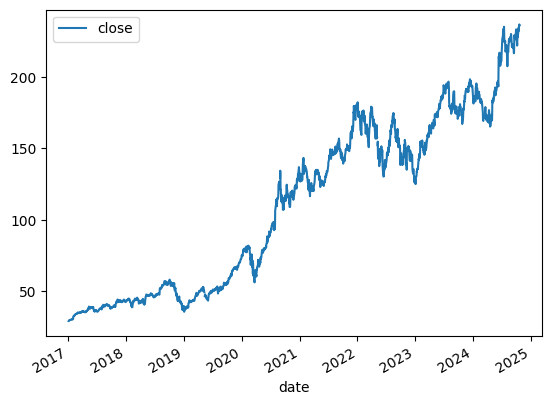

In [201]:
prices.plot(x='date', y='close')

<Axes: >

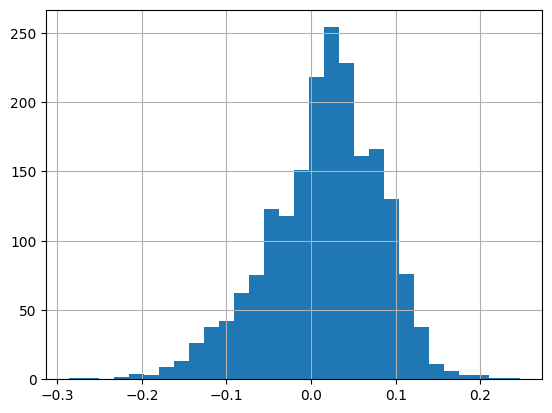

In [202]:
prices.target_log_returns.hist(bins=30)

Looks fine, though the price generally went up so we will want to compare to buy & hold. However there's also a bit of data leakage. Price data comes from [Yahoo](https://finance.yahoo.com/quote/AAPL/history/).

The close price is marked at 4pm ET (from the NYSE closing auction), i.e. 9pm UTC. The reddit post dates are UTC, so end at ~11:59pm UTC, so we are getting an extra 3 hours of data, in which time, news could come out and we might incorrectly think we could trade on that info at the close.

The best solution would be to shift our reddit dates by 3+ hours to account for this. In this example I will be lazy and just trade on *tomorrows* close instead, i.e. giving up 21 hours of data.

In [203]:
prices['target_log_returns'] = np.log(prices.close.shift(-15).ffill() / prices.close.shift(-1).ffill())

Time for my favourite function:

In [204]:
pearsonr(prices.score.fillna(0), prices.target_log_returns.fillna(0))

PearsonRResult(statistic=-0.07003879153146489, pvalue=0.0017422320356752289)

From this we can see there is a relatively strong (-0.07 is strong in most trading contexts) negative correlation between our scoring of reddit apple mentions in WSB and the 14 day future returns of apples stock price.

You can also see a p value which looks great and pretty significant! However this is not an accurate p-value. The calculation assumes that samples are independent which is not the case in our test. Because we are measuring 14 day returns, every row's target is overlapping with 13 other rows. 

A simple way to adjust for this is to simply downsample to every 14th row:

In [206]:
downsample = prices.iloc[::14, :].copy()
pearsonr(downsample.score.fillna(0), downsample.target_log_returns.fillna(0))

PearsonRResult(statistic=-0.10391407210906066, pvalue=0.21680368157025526)

That looks more accurate. The actual pvalue should *maybe* be higher or lower than this but it's a decent estimate. We effectively lost some proving power by dropping 13/14 rows, one way in theory to improve this is to groupby every 14 rows and take averages of each column. 

It's better to underestimate the effect than to overestimate it. Once we have many tickers, multiple data sources, and better models we should find more significant correlations.

(Also the statistic going from -0.07 to -0.1 is just random variance from having fewer samples).